In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import scipy.stats as stats
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions_AMSR2 import forward_OIB_AMSR2_new
from prepare_inputs_OE_AMSR2 import prepare_inputs_FYI_AMSR2_new as piO

In [2]:
def corrMat(self, data):
    ## Make correlation matrix - input covariance matrix
    corrMat = np.zeros(data.shape)
    sigmas = np.diag(data)**(1/2)
    rows = range(data.shape[0])
    cols = range(data.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(data)[row][col]/(sigma1*sigma2)

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(data.keys())), labels=data.keys())
    ax.set_yticks(np.arange(len(data.keys())), labels=data.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(data.keys())):
        for j in range(len(data.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output correlation matrix')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(V_sens) + '_CorrOut.png' )
    plt.show()
    
def covMat(self, data, title):
    for var in self.x_vars:
        print(var)
        data[var][var] = data[var][var]**(1/2)
    ## get std
    try:
       data['lex']['lex'] = data['lex']['lex']*1e1
    except:
        pass
    try:
        data['sal']['sal'] = data['sal']['sal']*1e1
    except:
        pass
    try:
        data['rho']['rho'] = data['rho']['rho']*1e-2
    except:
        pass
    try:
        data['Tsur']['Tsur'] = data['Tsur']['Tsur']/1e2
    except:
        pass
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data*1e2,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Modified Covariance [log10(cm),log10(mm),log10(PSU),cm]'}
    )
    ax.set_title(title)
    if 'out' in title:
        plt.savefig(savepath  + '_CovOut.png' )
    else:
        plt.savefig(savepath  +'_CovIn.png' )
    plt.show()
def makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB):
    nl_snow = 3
    forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                     "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
    oe = pyOE.optimalEstimation(
    x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
    ,forwardKwArgs=forwardKwArgs
    ,x_lowerLimit=x_lowerLimit
    ,x_upperLimit=x_upperLimit
    )
    return oe
def calc_ang(var1, var2):
    
    text_file = open(savepath + "angles_jacobian.txt", "a")
    
    J = oe.getJacobian(oe.x_op, oe.y_op)[0]
    print('--------------------------------------------------')
    text_file.write('--------------------------------------------------\n')
    
    denominator = np.linalg.norm(J['perturbed '+var1][:5])*np.linalg.norm(J['perturbed '+var2][:5])
    nominator = np.dot(J['perturbed '+var1][:5], J['perturbed '+var2][:5])
    print('Angle between '+var1+' and '+var2+' vector V:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector V:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')

    
    denominator = np.linalg.norm(J['perturbed '+var1][5:])*np.linalg.norm(J['perturbed '+var2][5:])
    nominator = np.dot(J['perturbed '+var1][5:], J['perturbed '+var2][5:])
    print('Angle between '+var1+' and '+var2+ ' vector H:', np.rad2deg(np.arccos(nominator/denominator)))
    text_file.write('Angle between '+var1+' and '+var2+' vector H:' + str(np.rad2deg(np.arccos(nominator/denominator))) + '\n')
def covOutMat(oe1, oe2, name):
    data=oe1/oe2
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(
        data,
        annot=True, 
        fmt='.4f', 
        ax=ax, 
        linewidths=.05, 
        cbar_kws={'label':'Ratio of covariance compared to input'}
    )
    ax.set_title('comparison')
    plt.savefig(savepath + str(name) + '_CovRatioOuttoIn.png' )
    plt.show()

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 23 13:58:39 2023

@author: Ida Olsen
"""
import numpy as np
import re
import matplotlib.pyplot as plt

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt import SMRTError
from sklearn.linear_model import LinearRegression
import os
import pyOptimalEstimation as pyOE
## self made modules
from roughness import roughness

class data():
    
    # init method or constructor
    def __init__(self, filename, dtype, ice_type=-1, empty=False):
        if empty == False:
            names = ["latitude","longitude","time","identification","sd_mean","sd_std","SDln","sit_mean","sit_std","SITln","FRB","FRBstd","Tsur","Tair","wsd","wdensity","lat1","lon1","time1","reference-id","69GHzH","69GHzV","73GHzH","73GHzV","107GHzH","107GHzV","187GHzH","187GHzV","238GHzH","238GHzV","365GHzH","365GHzV","890GHzH","890GHzV","Earth Incidence","Earth Azimuth","scanpos","upstreamfile","timediff","latitude2","longitude2","time2","reference-id2","upstreamfile","msl","u10","v10","ws","t2m","skt","istl1","istl2","istl3","istl4","sst","d2m","tcwv","tclw","tciw","ssrd","strd","e","tp","sf","fal","siconc","latitude3","longitude3","time3","reference-id3","upstreamfile","sigma_40","sigma_40_mask","nb_samples","warning","std","latitude4","longitude4","time4","reference-id4","upstreamfile","SMOS_Tbv","SMOS_Tbh","SMOS_RMSE_v","SMOS_RMSE_h","SMOS_nmp","SMOS_data1loss"]
            #print(filename)
            if "-NERSC-" in filename:
                print(filename)
                data1 = np.genfromtxt(filename, names=True, dtype=dtype,
                                     skip_header=1, delimiter=',', encoding='utf8')
            else:
                data1 = np.genfromtxt(filename, names=names, dtype=dtype,
                                     skip_header=1, delimiter=',', encoding='utf8')
    
            # self.subset   = []
            self.sd       = data1['sd_mean']
            self.sit      = data1['sit_mean']
    
            index_SD  = ~np.isnan(self.sd)
            index_SIT = ~np.isnan(self.sit)
            index = [(isd and isit) for isd,isit in zip(index_SD, index_SIT)]
            self.index = index
            if ice_type!=-1:
                index = np.where(self.index)[0][ice_type]
                self.index = index
                # print(index)
    
            self.sd       = data1['sd_mean'][index]
            self.sit      = data1['sit_mean'][index]
            self.lat      = data1['latitude'][index]
            self.lon      = data1['longitude'][index]
            self.date     = data1['time'][index]
            self.id       = data1['identification'][index]
            self.sd_std   = data1['sd_std'][index]
            self.sit_std  = data1['sit_std'][index]
            try:
                self.slope    = data1['surface_roughness_mean'][index]
                self.slope_std= data1['surface_roughness_std'][index]
            except:
                self.slope    = [np.nan for el in range(len(self.lat))]
                self.slope_std= [np.nan for el in range(len(self.lat))]
            self.t2m      = data1['t2m'][index]
            self.skt      = data1['skt'][index]
            self.tcwv     = data1['tcwv'][index]
            
            try:
                ## AMSR2 V
                self.tb6V     = data1['69V'][index]
                self.tb7V     = data1['73V'][index]
                self.tb10V    = data1['107V'][index]
                self.tb18V    = data1['187V'][index]
                self.tb23V    = data1['238V'][index]
                self.tb36V    = data1['365V'][index]
                self.tb89V    = data1['890V'][index]
                
                ## AMSR2 H
                self.tb6H     = data1['69H'][index]
                self.tb7H     = data1['73H'][index]
                self.tb10H    = data1['107H'][index]
                self.tb18H    = data1['187H'][index]
                self.tb23H    = data1['238H'][index]
                self.tb36H    = data1['365H'][index]
                self.tb89H    = data1['890H'][index]
            except:
                self.tb6V     = data1['69GHzV'][index]
                self.tb7V     = data1['73GHzV'][index]
                self.tb10V    = data1['107GHzV'][index]
                self.tb18V    = data1['187GHzV'][index]
                self.tb23V    = data1['238GHzV'][index]
                self.tb36V    = data1['365GHzV'][index]
                self.tb89V    = data1['890GHzV'][index]
                
                ## AMSR2 H
                self.tb6H     = data1['69GHzH'][index]
                self.tb7H     = data1['73GHzH'][index]
                self.tb10H    = data1['107GHzH'][index]
                self.tb18H    = data1['187GHzH'][index]
                self.tb23H    = data1['238GHzH'][index]
                self.tb36H    = data1['365GHzH'][index]
                self.tb89H    = data1['890GHzH'][index]
            
            ## Gradient ratio
            self.GR_69_187_V  = (self.tb18V-self.tb6V)/(self.tb18V+self.tb6V)
            self.GR_187_365_V = (self.tb36V-self.tb18V)/(self.tb36V+self.tb18V)
            self.sigma40      = data1['sigma_40'][index]
            
            self.TbV_AMSR = [[tb6V, tb10V, tb18V, tb23V, tb36V] for tb6V, tb10V, tb18V, tb23V, tb36V
                             in zip(self.tb6V, self.tb10V, self.tb18V, self.tb23V, self.tb36V)]
            self.TbH_AMSR = [[tb6H, tb10H, tb18H, tb23H, tb36H] for tb6H, tb10H, tb18H, tb23H, tb36H
                             in zip(self.tb6H, self.tb10H, self.tb18H, self.tb23H, self.tb36H)]
        elif empty == True:

            # self.subset   = []
            self.sd       = []
            self.sit      = []
            self.index    = []
            self.lat      = []
            self.lon      = []
            self.date     = []
            self.id       = []
            self.sd_std   = []
            self.sit_std  = []
            self.slope     = []
            self.slope_std = []
            self.t2m      = []
            self.skt      = []
            self.tcwv     = []
            ## AMSR2 V
            self.tb6V     = []
            self.tb7V     = []
            self.tb10V    = []
            self.tb18V    = []
            self.tb23V    = []
            self.tb36V    = []
            self.tb89V    = []
            
            ## AMSR2 H
            self.tb6H     = []
            self.tb7H     = []
            self.tb10H    = []
            self.tb18H    = []
            self.tb23H    = []
            self.tb36H    = []
            self.tb89H    = []
            
            ## Gradient ratio
            self.GR_69_187_V  = []
            self.GR_187_365_V = []
            self.sigma40      = []
            
            self.TbV_AMSR = []
            self.TbH_AMSR = []
            
    def concatenate(self, obj2):
        " Concatenate two class objects e.g. combine to one"
        # update directory of obj1 with informaiton from obj2
        # self.__dict__.update(obj2.__dict__)
        
        for dict1, dict2 in zip(self.__dict__.items(), obj2.__dict__.items()):
            # dict[0] = keys e.g. class names
            # dict[1] = values in keys e.g. values of a given key
            setattr(self, dict1[0], np.append(dict1[1],dict2[1]))

    def plot(self, varname):

        if varname in self.__dict__.keys():
            var=self.__dict__.get(varname)
            title = ('OIB distribution of ' + varname.upper())
            if self.subset == "FYI":
                # clim = [1, 2]
                clim = [240,260]
            elif self.subset == "MYI":
                clim = [2, 6]
            else: # snow values
                clim = [0, 1]
            po(self.lat, self.lon, var, title + " " + self.subset, ylabel=varname.upper() + ' [m]', clim=clim, s=10)
        else:
            print('ERROR variable in in class')
            print('Class attributes are:', self.__dict__.keys())

def Get_OIB_data(directory_path, all_data=True,plot=False):

    # directory_path = os.path.dirname(os.path.dirname(os.getcwd()))
    if all_data==True:
        datafolder= "ALL_DATA" #"2013-2019"
    elif all_data=="old":
        datafolder= "2009-2015"
    elif all_data=="new":
        datafolder= "2016-2019"
    sourcedir = directory_path + "/RRDP_v2.2/NERSC_OIB/"+datafolder+"/*.text"
    file = "QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.TEXT"

    files = os.listdir(directory_path +  "/RRDP_v2.2/NERSC_OIB/"+datafolder+"/")
    ifile = os.path.join(directory_path, "RRDP_v2.2/NERSC_OIB/"+datafolder+"/" + files[0])
    dtype = float
    ## make empty class object
    d_final_FYI = data(ifile, dtype, [])
    d_final_MYI = data(ifile, dtype, [])
    
    ## loop throguh files
    for file in files:
        filename = os.path.join(directory_path, "RRDP_v2.2/NERSC_OIB/"+datafolder+"/" + file)
        data_np = np.genfromtxt(filename, skip_header=1, delimiter=',', encoding='utf8')
        if "-NERSC-" in filename:
            dtype = [float if (e!=2 and e!=3 and e!=21 and e!=22 and e!=23) else object for e in list(range(data_np.shape[1]))]
        else:
            dtype = [float if (e!=2 and e!=3) else object for e in list(range(data_np.shape[1]))]
        print(filename)
        d = data(filename, dtype)            
        #% FYI/MYI based on scatter  
        ## exclude the 10% of measurements with the heighest std
        exclude_points_SD = int(len(d.sd_std)/10)
        exclude_points_SIT = int(len(d.sit_std)/10)
        
        ## argpartition (orders based on size)
        ind_SD = np.argpartition(d.sd_std, -exclude_points_SD)[-exclude_points_SD:]
        ind_SIT = np.argpartition(d.sit_std, -exclude_points_SIT)[-exclude_points_SIT:]
        
        FYI = [];
        MYI = [];
        
        for i in range(len(d.GR_69_187_V)):
            if d.GR_69_187_V[i]<0.015 and d.GR_187_365_V[i]>-0.03 and d.sigma40[i]<-16.5 and d.sit[i]<2.0 and any(i!=ind_SD) and any(i!=ind_SIT):
                FYI.append(i)
            elif d.GR_69_187_V[i]<0 and d.GR_187_365_V[i]<-0.06 and d.sigma40[i]>-12 and d.sit[i]>2 and any(i!=ind_SD) and any(i!=ind_SIT):
                MYI.append(i)
        
        d_FYI = data(filename, dtype, FYI)
        d_MYI = data(filename, dtype, MYI)
    
        ## Make final class object with FYI and MYI data
        d_final_FYI.concatenate(d_FYI)
        d_final_MYI.concatenate(d_MYI)
        
        d_final_FYI.subset = "FYI"
        d_final_MYI.subset = "MYI"
    if plot==True:
        d_final_FYI.plot('sit')
        d_final_MYI.plot('sit')
    return [d_final_FYI, d_final_MYI]

class smrt_values():
    # init method or constructor
    def __init__(self, OIB_data, frac=0.25):
        #
        self.pol = 'both'
        self.Tsur = OIB_data.skt # np.mean(OIB_data.skt)
        self.m = 0.19 # roughness variable
        self.tcwv = OIB_data.tcwv # np.mean(OIB_data.tcwv) #total columnar water vapour
        self.ks = 0.25
        # Snow variables
        sd_tot = OIB_data.sd # np.mean(OIB_data.sd)
        sd0 = sd_tot - sd_tot*frac
        sd1 = sd_tot*frac - 0.01
        sd2 = 0.01
        self.sd = [sd0, sd1, sd2]
        self.lex = [0.24e-3, 0.37e-3, 0.37e-3] ## mm - based on paper by Wisman and Metzler
        self.sal = [0.001*PSU, 0.5*PSU, 13*PSU]  # Based on CB field observations 
        self.rho = [350, 270, 270] # based on paper by Wisman and Metzler
        # Ice varibles
        self.sit = OIB_data.sit # np.mean(OIB_data.sit)
        self.sit_lex = 0.15e-3
        self.sit_sal = 6*PSU
        # Temperatures
    def calc_temp(self, plot=True):
        k = 2.10 # thermal conductivity FYI
        T_w = (273.15-1.8)  # Ocean temperature [K]
        ks = self.ks # Thermal conductivity of snow [w/(m*K)]

        ## snow ice interface temperature
        self.T_sii = (k * np.sum(self.sd) * T_w + ks * self.sit *
                    self.Tsur) / (k * np.sum(self.sd) + ks * self.sit)
        x = [0, np.sum(self.sd)]
        y = [self.Tsur, self.T_sii]
        model = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y))
        xx = np.array([self.sd[0]/2, self.sd[0] + self.sd[1]/2, self.sd[0]+ self.sd[1] + self.sd[2]/2] ).reshape(-1,1)
        self.Tsnow = model.predict(xx)
        
        #if plot==True:
        # ice/snow thickness arrays for showing temperature profiles    
        ice_thick = np.array([0, -self.sit])
        t_ice = np.array([self.T_sii, T_w])

def SMRT_simulation(self):
    
    
    
    ## Make icepack           
    sea_ice_density = 900
    icepack = make_ice_column(ice_type='firstyear',
            thickness=[self.sit], 
            temperature=[self.T_sii], 
            microstructure_model='exponential',
            corr_length=[self.sit_lex],
            brine_inclusion_shape='spheres',
            density=sea_ice_density,
            salinity=[self.sit_sal],
            add_water_substrate="ocean")

    
    self.calc_temp(plot=False)
    
    snowpack = make_snowpack(self.sd, 
                    microstructure_model='exponential',
                    ice_permittivity_model=ssp, 
                    density=self.rho, 
                    corr_length=self.lex, 
                    temperature = self.Tsnow,
                    salinity=self.sal)
    medium = snowpack + icepack
    
    
    m = make_model("iba", "dort")
    
    frequencies=np.array([6.925e9,10.65e9,18.7e9,23.8e9,36.5e9]);  # [Hz]
    
    beamorientation = 55. # [degrees]
    sensor = sensor_list.passive(frequencies, beamorientation)
    
    #% Run simulations
    res = m.run(sensor, medium)

    # #% adjust for atmospheric influence    
    [TB_AMSR_V,TB_AMSR_H, Gamma_rs_H, Gamma_rs_V, QH, QV] = roughness(self.tcwv,res,self.T_sii, m=self.m)
    
    Bias_TBV = np.array([0.546, 1.753, 0.749, -0.020, 0.088])
    Bias_TBH = np.array([1.565, 3.240, 0.454, -0.097, -1.803])
    return [TB_AMSR_V+Bias_TBV,TB_AMSR_H+Bias_TBH]


directory_path = os.path.dirname(os.path.dirname(os.getcwd()))
[d_final_FYI, d_final_MYI] = Get_OIB_data(directory_path, all_data=True,plot=False)
[data_save, not_important] = Get_OIB_data(directory_path, all_data=True,plot=False)


C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20090331.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130323.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130324.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NE

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150403.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2016_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2017_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/SMOS-vs-ASCAT-vs-ERA5-vs-refAMSR2-vs-2018_OIB_RRDB.text
C:\Users\Ida Olsen\Documents\Spe

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20110415.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20110415.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20110415.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR-vs-ERA-vs-NERSC-OIB-20110415.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130320.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20130320.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140317.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140317.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140317.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140317.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140318.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20140318.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NE

C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150327.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150327.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150327.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150327.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150329.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NERSC-OIB-20150329.text
C:\Users\Ida Olsen\Documents\Speciale_2022\RRDP_v2.2/NERSC_OIB/ALL_DATA/QSCAT-vs-SMAP-vs-SMOS-vs-ASCAT-vs-AMSR2-vs-ERA-vs-NE

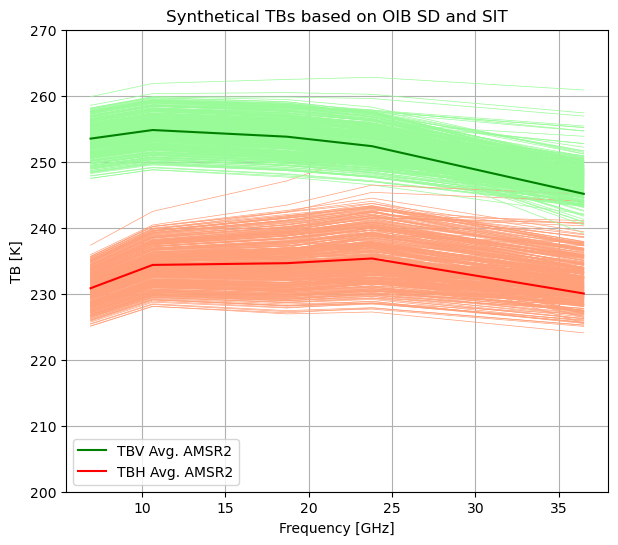

In [4]:
TBV_SIM = []
TBH_SIM = []
plt.figure(figsize=(7,6))
for sd, sit, skt, tcwv in zip(d_final_FYI.sd, d_final_FYI.sit, d_final_FYI.skt, d_final_FYI.tcwv):
    data_save.sd = sd
    data_save.sit = sit
    data_save.skt = skt
    data_save.tcwv = tcwv
    ## data
    data = smrt_values(data_save)
    data.calc_temp(plot=False)
    data.lex = np.array(data.lex)
    # for lex in np.linspace(data.lex-0.05*1e-3, data.lex+0.05*1e-3, 3):
        
    # data.lex = lex
    [TB_AMSR_V,TB_AMSR_H] = SMRT_simulation(data)
    frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
    freqs = [f*1e-9 for f in frequencies]
    y = TB_AMSR_V
    plt.plot(freqs, y, c='palegreen',linewidth=0.5)
    y = TB_AMSR_H
    plt.plot(freqs, y, c='lightsalmon',linewidth=0.5)

    TBV_SIM.append(TB_AMSR_V)
    TBH_SIM.append(TB_AMSR_H)

y = np.mean(d_final_FYI.TbV_AMSR.reshape((-1,5)), axis=0)
plt.plot(freqs, y, c='g',label = 'TBV Avg. AMSR2')
y = np.mean(d_final_FYI.TbH_AMSR.reshape((-1,5)), axis=0)
plt.plot(freqs,y, c='r', label = 'TBH Avg. AMSR2')
plt.grid()
plt.ylim([200,270])
plt.legend(loc="lower left") # bbox_to_anchor=(1, 0.8))
plt.xlabel('Frequency [GHz]')
plt.ylabel('TB [K]')
plt.title('Synthetical TBs based on OIB SD and SIT')
plt.show()

In [5]:
# Saving location
savepath = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Results/SIMULATED_DATA/Report/'

# Numebr of layers
nl_snow = 3
# Polarization (V or both)
polarization = 'both'
# sensitivity of TBs (std)
V_sens = 0.5 # K
H_sens = 1.5 # K
# List with input variables
input_variables = ["SD", "SIT"]

### Choose looking at only V or at both

### Choose how many input variables 

### choose Sy sensitivity

In [6]:
## Define name of y-variables

y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"]

# y_obs  = np.concatenate([np.mean(d_final_FYI.TbV_AMSR.reshape((-1,5)), axis=0), np.mean(d_final_FYI.TbH_AMSR.reshape((-1,5)), axis=0)])
y_obs  = np.concatenate([np.mean(np.array(TBV_SIM).reshape((-1,5)), axis=0), np.mean(np.array(TBH_SIM).reshape((-1,5)), axis=0)])
V_sens = 0.5
H_sens = 0.5
y_cov = np.diag([V_sens**2]*5 + [H_sens**2]*5)

# Define name of x-variable
x_vars = input_variables
## prepare first guess, covariance matrix, upper and lower limits
# [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(d_final_FYI, x_vars, logarithmic=True, nl_snow=nl_snow)

Text(0.5, 1.0, 'Measurement uncertainty (STD) $\\mathbf{S}_{y}$')

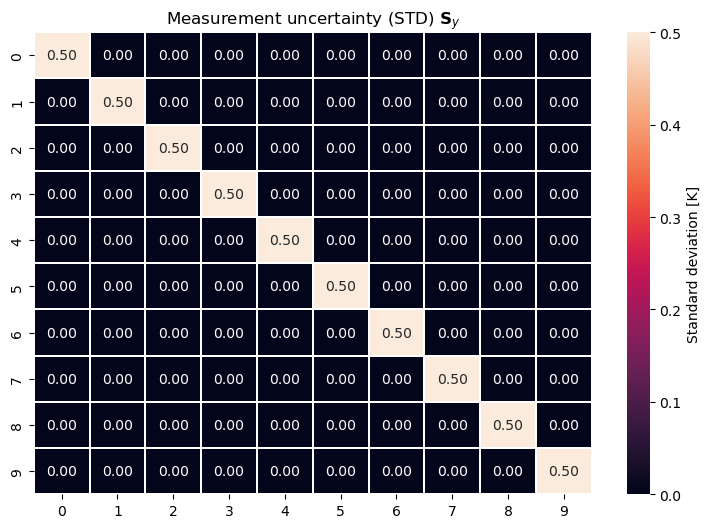

In [7]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    np.sqrt(y_cov), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Standard deviation [K]'}
)
ax.set_title(r'Measurement uncertainty (STD) $\mathbf{S}_{y}$')

[0.13437566 1.44846296]
[0.00222611 0.09194532]
0.84 s, iteration 1, degrees of freedom: 1.95 of 2, not converged (x-space):  2.511
1.19 s, iteration 2, degrees of freedom: 1.93 of 2, converged (x-space):  0.014
1.56 s, iteration 3, degrees of freedom: 1.93 of 2, done.  0.005
-----------------
TRUE VALUES
-----------------
SD:  0.1343756613756614
lex:  [0.00024, 0.00037, 0.00037]
rho:  [350, 270, 270]
sal:  [1.0e-03 5.0e-01 1.3e+01]
SIT:  1.448462962962963
-----------------
SD     0.099346
SIT    1.084785
dtype: float64
-----------------
Jacobian matrix:
      perturbed SD  perturbed SIT
6V      38.251136      -3.626290
10V     39.898535      -3.646084
18V     40.805470      -5.206530
23V     36.533020      -4.338432
36V     18.536927      -8.709592
6H      38.758892      -3.422449
10H     44.611003      -3.733005
18H     56.560337      -5.952991
23H     57.685004      -5.423179
36H     46.792339      -9.447955


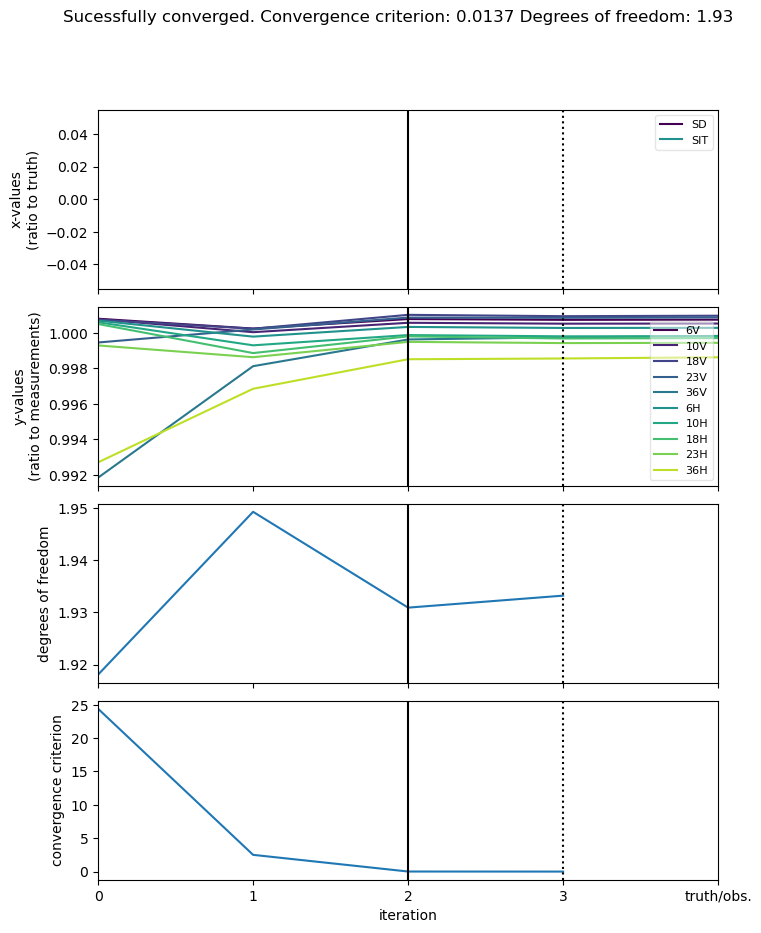

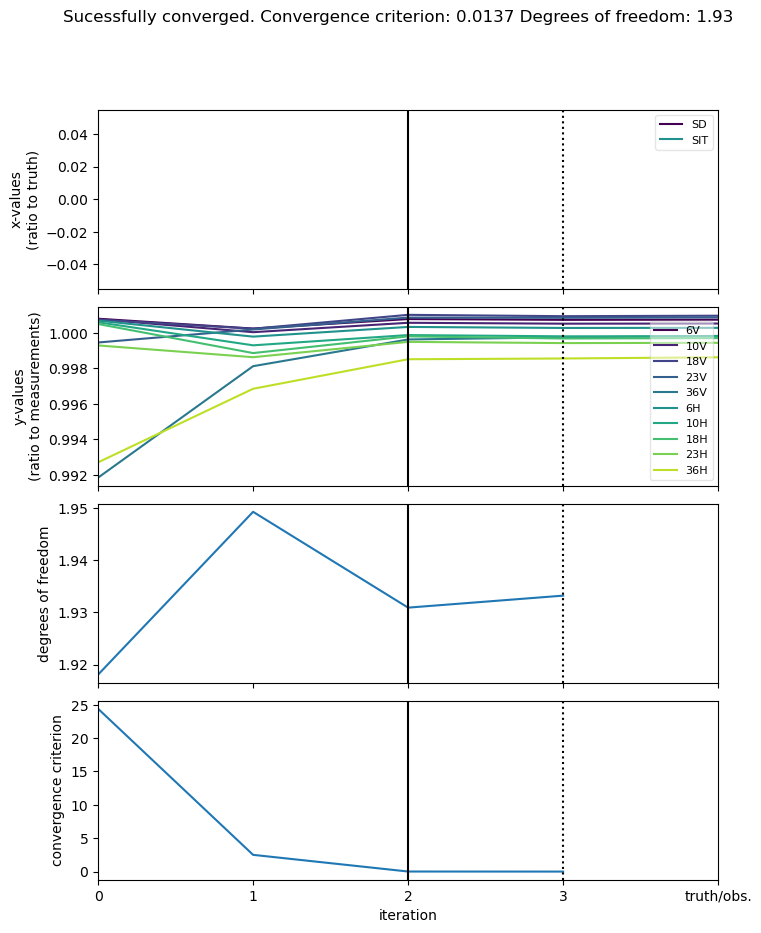

In [8]:
## Iterate over different start guesses
data = smrt_values(d_final_FYI)
#data.skt=data.Tsur
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(d_final_FYI, x_vars, logarithmic=False, nl_snow=3)
print(x_ap)
print(np.diag(x_cov))


forwardKwArgs = {"self": d_final_FYI, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                 "pol":"both", "logarithmic":False,"avg":True}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2_new
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        ,convergenceFactor=10
        )
# run the optimization and print outputs
oe.doRetrieval(maxIter=15)
print('-----------------')
print('TRUE VALUES')
print('-----------------')
print('SD: ', np.mean(d_final_FYI.sd))
print('lex: ', data.lex)
print('rho: ', data.rho)
print('sal: ', np.array(data.sal)*1e3)
print('SIT: ',np.mean(d_final_FYI.sit))

print('-----------------')
print(oe.x_op)

print('-----------------')
print('Jacobian matrix:\n', oe.getJacobian(oe.x_op, oe.y_op)[0])
oe.plotIterations()

In [9]:
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2_new)
covOutMat(oe.S_op, oe_show.S_a, name='Avg_vals')

NameError: name 'FYI_data' is not defined

In [ ]:
## calculate angles if we have more than 1 input variable
text_file = open(savepath + "angles_jacobian.txt", "w")
if len(input_variables)>1:
    for i in range(len(input_variables)):
        for j in range(len(input_variables)):
            if i!=j:
                calc_ang(input_variables[i], input_variables[j])

In [ ]:
## Plots results
plt.figure(figsize=(8,6))
frequencies=[6.925e9,10.65e9,18.7e9,23.8e9,36.5e9];
freqs = [f*1e-9 for f in frequencies]

y = np.mean(np.array(TBV_SIM).reshape((-1,5)), axis=0)
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = np.mean(np.array(TBH_SIM).reshape((-1,5)), axis=0)
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = np.mean(np.array(d_final_FYI.TbV_AMSR).reshape((-1,5)), axis=0)
plt.plot(freqs, y, c='r',label = 'TBV Avg. AMSR2')
y = np.mean(np.array(d_final_FYI.TbH_AMSR).reshape((-1,5)), axis=0)
plt.plot(freqs,y, c='b', label = 'TBH Avg. AMSR2')
y = oe.y_op[:5]
plt.plot(freqs, y, c='k', label = 'TBV Avg. SIM')
if polarization =='both':
    y = oe.y_op[5:]
    plt.plot(freqs, y, c='green', label = 'TBH Avg. SIM')
plt.grid()
plt.ylim([200,270])
plt.legend()
plt.xlabel('Freq GHz')
plt.ylabel('TB [K]')
plt.title('Simulated FYI TBs from OIB data 2013-2019')
# plt.savefig(os.path.join(self.pp, 'OE_figures/Simulated_data.png'), bbox_inches='tight')
plt.show()

### Test for assumptions

In [ ]:
## Iterate over different start guesses (of SD)
slope_std ='medium_sy_test'

for var in input_variables:
    [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, logarithmic=True, nl_snow=nl_snow)
    
    #x_cov[0,0] = x_cov[0,0]*2
    #x_cov[2,2] = 0.02**2
    cc = []
    x_op = []
    ind = [i==var for i in input_variables]
    if var=='SD':
        V0 = np.linspace(np.log10(0.08), np.log10(0.25), 10)
    elif var=='lex':
        V0 =  np.linspace(np.log10(0.2*1e-3), np.log10(0.4*1e-3), 10)
    elif var=='sal':
        V0 =  np.linspace(5*PSU, 20*PSU, 10)
        # V0 =  np.linspace(np.log10(0.1*PSU), np.log10(2*PSU), 10)
    elif var=='rho':
        V0 = np.linspace(200, 400, 10)
    elif var=='SIT':
        V0 = np.linspace(0.5, 2.0, 10)
    elif var=='slope':
        V0 = np.linspace(0.05, 0.3, 10)

    for v0 in V0:
        x_ap[ind] =v0
        ## define extra arguments to forward function
        forwardKwArgs = {"self": FYI_data, "variables": x_vars, "nl_snow": nl_snow, "n": 0, 
                         "pol":polarization, "logarithmic":True,"avg":True, "sim":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,x_truth=x_truth
                ,convergenceFactor=10
                )

        try:
            # run the optimization and print outputs
            oe.doRetrieval(maxIter=6)
            oe.plotIterations
            cc.append(oe.S_op)
            x_op.append(oe.x_op)
        except:
            print('NC')
            V0 = np.delete(V0, [np.where(V0==v0)])
        
    ## Plot results
    plt.figure(figsize=(7,7))
    # print(var)
    for i in range(len(input_variables)):
        print(i)
        
        if input_variables[i]!="SIT" and input_variables[i]!="rho" and input_variables[i]!="sal" and input_variables[i]!="slope":
            V = [10**x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        else:
            V = [x[input_variables[i]] for x in x_op if ~np.isnan(x).any()]
        if var!="SIT" and var!="rho" and var!="sal" and var!='slope':
            VV0 = [10**v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        else:
            VV0 = [v0 for v0,x in zip(V0, x_op) if ~np.isnan(x).any()]
        if input_variables[i]=="lex" or input_variables[i]=="sal":
            V = np.array(V)*1e3
        if var=="lex" or var=="sal":
            VV0 = np.array(VV0)*1e3
        if var=="sal":
            VV0 = VV0/100
        if input_variables[i]=="sal":
            V=V/100
        if var=='rho':
            VV0 = np.array(VV0)/1000
        if input_variables[i]=="rho":
            V = np.array(V)/1000
        if var=="SIT":
            VV0 = np.array(VV0)/10
        if input_variables[i]=="SIT":
            V=np.array(V)/10
        # print(VV0)
        # print(V)
        plt.scatter(VV0, V, label=input_variables[i])
    print(np.mean(10**FYI_data.sd))
    plt.xlabel(var + ' start guess')
    plt.ylabel(var +' OE')
    plt.axhline(np.mean(10**FYI_data.sd), color='k', label='mean OIB SD')
    plt.axhline(np.mean(FYI_data.sit)/10, color='grey', label='mean OIB SIT/10')
    # plt.axhline(np.mean(FYI_data.sd_lex, axis=0)[0]*1e3, color='b', label='mean OIB lex')
    # plt.axhline(np.mean(FYI_data.sd_sal, axis=0)[0]*1e3/3, color='r', label='mean OIB sal/3')
    plt.xlim([0.04, 0.41])
    plt.ylim([0.04, 0.41])
    #plt.xlim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    #plt.ylim([np.min(VV0)-np.min(VV0)/10,np.max(VV0)+np.max(VV0)/10])
    plt.legend()
    plt.grid()
    plt.savefig(savepath + var + '_' + str(slope_std) + '.png' )
    plt.show()

In [ ]:
try:
    #def corrMat(data):
    corrMat = np.zeros(oe.S_op.shape)
    sigmas = np.diag(oe.S_op)**(1/2)
    rows = range(oe.S_op.shape[0])
    cols = range(oe.S_op.shape[1])
    for row in rows:
        sigma1 = sigmas[row]
        for col in cols:
            sigma2 = sigmas[col]

            corrMat[row][col] = np.array(oe.S_op)[row][col]/(sigma1*sigma2)




    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(corrMat, cmap="inferno")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())
    ax.set_yticks(np.arange(len(oe.S_op.keys())), labels=oe.S_op.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    for i in range(len(oe.S_op.keys())):
        for j in range(len(oe.S_op.keys())):
            if np.round(corrMat[i, j],2) > 0.5:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                       ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, np.round(corrMat[i, j],2),
                               ha="center", va="center", color="w")

    ax.set_title(r'Output uncertainty $\mathbf{S}_{op}$')
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


    fig.tight_layout()
    plt.savefig(savepath + str(slope_std) + '_CorrMatrixOut.png' )
    plt.show()
except:
    print('last iteration not converged')

In [16]:
ns = 250
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(d_final_FYI, x_vars, logarithmic=False, nl_snow=3)

polarization='both'

def do_OE_sim(ns, noise=False):
    if polarization=='both':
        data=zip(np.array(TBV_SIM).reshape((-1,5))[:ns], np.array(TBH_SIM).reshape((-1,5))[:ns])
    elif polarization=='V':
        data=FYI_data.TbV_AMSR_all[:ns]
    elif polarization=='VH0':
        data=zip(FYI_data.TbV_AMSR_all[:ns], FYI_data.TbH_AMSR_all[:ns][:,0])
    oe_out = []
    results = []
    x_optimals = []
    nn = [] 
    no = []
    for Tb, n in zip(data, range(len(d_final_FYI.skt[:ns]))):
        # [x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = piO(FYI_data, x_vars, n=n, logarithmic=True, nl_snow=nl_snow)
        print('Point number: ', n)
        # y_obs = np.append(Tb[0],Tb[1])
        #print(y_obs)
        y_obs = np.concatenate(Tb)
        ## define extra arguments to forward function

        forwardKwArgs = {"self": d_final_FYI, "variables": x_vars, "nl_snow": nl_snow, "n": n, 
                         "pol":"both", "logarithmic":False,"avg":False}
        # define the optimal estimation
        oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2_new
                ,forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit
                ,x_upperLimit=x_upperLimit
                ,convergenceFactor=10
        )
        try:
            oe.doRetrieval(maxIter=10)
            nn.append(n)
            x_optimals.append(oe.x_op)
            results.append(oe.y_op)
            oe_out.append(oe)
            
        except:
            print('Convergence not reached')
            no.append(n)
    return [nn, no, oe_out, x_optimals, results]

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

def RMSE(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
    return RMSE

In [ ]:
for oe,tbv,tbh in zip(oe_out,np.array(TBV_SIM).reshape((-1,5))[:ns], np.array(TBH_SIM).reshape((-1,5))[:ns]):
    try:
        plt.plot(frequencies, oe.y_op[:5], c='r')
        plt.plot(frequencies, oe.y_op[5:], c='g')
        plt.plot(frequencies,tbv, c='orange')
        plt.plot(frequencies,tbh, c='b')
    except:
        pass
    plt.grid()
    plt.ylim([200,260])

Point number:  0
0.77 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  48.755
1.12 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.013
1.46 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  1
0.77 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  3.120
1.10 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.014
1.44 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  2
0.77 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  17.672
1.10 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.014
1.43 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  3
0.79 s, iteration 1, degrees of freedom: 1.98 of 2, not converged (x-space):  26.942
1.12 s, iteration 2, degrees of freedom: 1.98 of 2, not converged (x-space):  9.993
1.46 s, iteration 3, degrees of freedom: 1.98 of 2, not converged (x-space

1.18 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.000
1.55 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  30
0.85 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  2.034
1.22 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.003
1.59 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  31
0.84 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  12.370
1.20 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.005
1.57 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  32
0.84 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  24.320
1.21 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.010
1.57 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  33
0.86 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  9.381
1.24 s, it

0.83 s, iteration 1, degrees of freedom: 1.99 of 2, converged (x-space):  0.080
1.19 s, iteration 2, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  58
0.84 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  41.449
1.20 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.000
1.57 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  59
0.85 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  36.396
1.22 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.012
1.60 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.001
Point number:  60
0.87 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  40.198
1.24 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.012
1.61 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  61
0.87 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  30.477
1.23 s, 

1.54 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  85
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  0.202
1.20 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.136
1.56 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.119
Point number:  86
0.83 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  3.131
1.24 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.000
1.60 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  87
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  6.119
1.18 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.001
1.54 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  88
0.83 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  157.440
1.19 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.065
1.54 s, it

1.55 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  112
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  10.284
1.18 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.016
1.54 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  113
0.85 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  2.631
1.20 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.000
1.57 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  114
0.84 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  1.294
1.20 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.000
1.56 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  115
0.85 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  13.219
1.23 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.022
1.61 s

0.87 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  64.490
1.24 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.024
1.60 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  137
0.80 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  10.096
1.16 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.016
1.52 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  138
0.85 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  1.411
1.18 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.000
1.53 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  139
0.84 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  0.209
1.19 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.199
1.55 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.187
Point number:  140
0.86 s

0.84 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  153.809
1.18 s, iteration 2, degrees of freedom: 2.00 of 2, not converged (x-space):  0.337
1.54 s, iteration 3, degrees of freedom: 2.00 of 2, converged (x-space):  0.001
1.89 s, iteration 4, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  160
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  798.934
1.18 s, iteration 2, degrees of freedom: 2.00 of 2, not converged (x-space):  18.937
1.53 s, iteration 3, degrees of freedom: 2.00 of 2, not converged (x-space):  9.989
1.90 s, iteration 4, degrees of freedom: 2.00 of 2, not converged (x-space):  5.931
2.26 s, iteration 5, degrees of freedom: 2.00 of 2, not converged (x-space):  3.269
2.63 s, iteration 6, degrees of freedom: 2.00 of 2, not converged (x-space):  1.833
2.99 s, iteration 7, degrees of freedom: 2.00 of 2, not converged (x-space):  1.043
3.33 s, iteration 8, degrees of freedom: 2.00 of 2, not converged (x-space)

0.79 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  8.184
1.15 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.008
1.50 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  177
0.82 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  3.624
1.19 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.002
1.54 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  178
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  118.669
1.17 s, iteration 2, degrees of freedom: 1.99 of 2, not converged (x-space):  21.073
1.54 s, iteration 3, degrees of freedom: 1.99 of 2, converged (x-space):  0.154
1.89 s, iteration 4, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  179
0.82 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  170.632
1.17 s, iteration 2, degrees of freedom: 1.99 of 2, not converged (x-space):  2.183

1.52 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  199
0.83 s, iteration 1, degrees of freedom: 1.96 of 2, not converged (x-space):  1266.664
1.21 s, iteration 2, degrees of freedom: 1.98 of 2, not converged (x-space):  476.220
1.56 s, iteration 3, degrees of freedom: 2.00 of 2, not converged (x-space):  41.513
1.92 s, iteration 4, degrees of freedom: 1.99 of 2, not converged (x-space):  5.703
2.29 s, iteration 5, degrees of freedom: 1.99 of 2, not converged (x-space):  0.500
2.66 s, iteration 6, degrees of freedom: 1.99 of 2, converged (x-space):  0.046
3.02 s, iteration 7, degrees of freedom: 1.99 of 2, done.  0.004
Point number:  200
0.81 s, iteration 1, degrees of freedom: 1.86 of 2, not converged (x-space):  4236.071
1.17 s, iteration 2, degrees of freedom: 1.99 of 2, not converged (x-space):  1325.852
1.52 s, iteration 3, degrees of freedom: 1.99 of 2, not converged (x-space):  387.101
1.87 s, iteration 4, degrees of freedom: 1.99 of 2, not converged 

2.70 s, iteration 6, degrees of freedom: 2.00 of 2, not converged (x-space):  45.474
3.05 s, iteration 7, degrees of freedom: 2.00 of 2, not converged (x-space):  52.548
3.42 s, iteration 8, degrees of freedom: 2.00 of 2, not converged (x-space):  60.691
3.78 s, iteration 9, degrees of freedom: 2.00 of 2, not converged (x-space):  70.054
Point number:  216
0.82 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  1335.470
1.18 s, iteration 2, degrees of freedom: 1.99 of 2, not converged (x-space):  279.699
1.53 s, iteration 3, degrees of freedom: 1.99 of 2, not converged (x-space):  21.724
1.89 s, iteration 4, degrees of freedom: 1.99 of 2, converged (x-space):  0.008
2.25 s, iteration 5, degrees of freedom: 1.99 of 2, done.  0.000
Point number:  217
0.83 s, iteration 1, degrees of freedom: 1.98 of 2, not converged (x-space):  990.924
1.19 s, iteration 2, degrees of freedom: 1.99 of 2, not converged (x-space):  314.105
1.55 s, iteration 3, degrees of freedom: 2.00 o

1.14 s, iteration 2, degrees of freedom: 2.00 of 2, converged (x-space):  0.053
1.49 s, iteration 3, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  235
0.82 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  433.130
1.16 s, iteration 2, degrees of freedom: 2.00 of 2, not converged (x-space):  18.838
1.53 s, iteration 3, degrees of freedom: 2.00 of 2, converged (x-space):  0.050
1.89 s, iteration 4, degrees of freedom: 2.00 of 2, done.  0.001
Point number:  236
0.83 s, iteration 1, degrees of freedom: 2.00 of 2, not converged (x-space):  1594.586
1.18 s, iteration 2, degrees of freedom: 2.00 of 2, not converged (x-space):  17.421
1.53 s, iteration 3, degrees of freedom: 2.00 of 2, converged (x-space):  0.013
1.88 s, iteration 4, degrees of freedom: 2.00 of 2, done.  0.000
Point number:  237
0.81 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  2417.962
1.17 s, iteration 2, degrees of freedom: 2.00 of 2, not converged (x-space):  

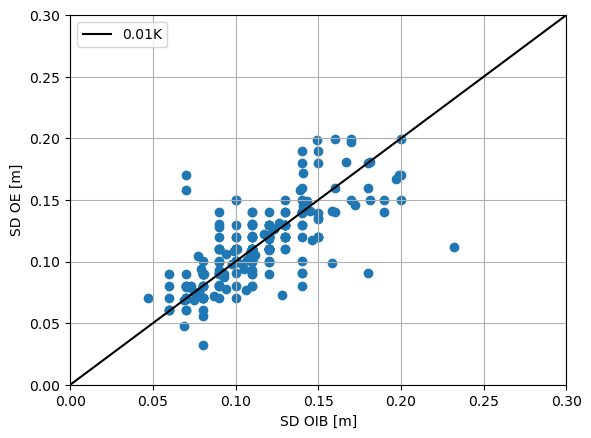

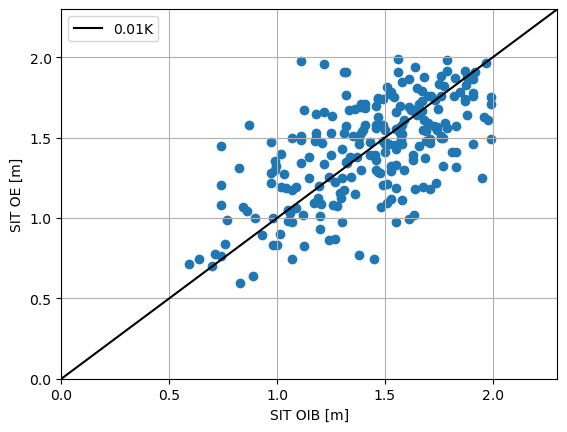

Point number:  0
0.86 s, iteration 1, degrees of freedom: 1.90 of 2, not converged (x-space):  1.702
1.26 s, iteration 2, degrees of freedom: 1.90 of 2, converged (x-space):  0.001
1.65 s, iteration 3, degrees of freedom: 1.90 of 2, done.  0.000
Point number:  1
0.85 s, iteration 1, degrees of freedom: 1.85 of 2, converged (x-space):  0.085
1.22 s, iteration 2, degrees of freedom: 1.84 of 2, done.  0.000
Point number:  2
0.85 s, iteration 1, degrees of freedom: 1.86 of 2, not converged (x-space):  1.043
1.22 s, iteration 2, degrees of freedom: 1.86 of 2, converged (x-space):  0.001
1.59 s, iteration 3, degrees of freedom: 1.86 of 2, done.  0.000
Point number:  3
0.82 s, iteration 1, degrees of freedom: 1.66 of 2, not converged (x-space):  0.805
1.19 s, iteration 2, degrees of freedom: 1.71 of 2, converged (x-space):  0.127
1.58 s, iteration 3, degrees of freedom: 1.67 of 2, done.  0.007
Point number:  4
0.85 s, iteration 1, degrees of freedom: 1.74 of 2, not converged (x-space):  4.379

0.91 s, iteration 1, degrees of freedom: 1.79 of 2, not converged (x-space):  1.514
1.30 s, iteration 2, degrees of freedom: 1.78 of 2, converged (x-space):  0.001
1.69 s, iteration 3, degrees of freedom: 1.78 of 2, done.  0.000
Point number:  35
0.82 s, iteration 1, degrees of freedom: 1.87 of 2, not converged (x-space):  13.031
1.18 s, iteration 2, degrees of freedom: 1.82 of 2, not converged (x-space):  1.527
1.53 s, iteration 3, degrees of freedom: 1.83 of 2, converged (x-space):  0.002
1.88 s, iteration 4, degrees of freedom: 1.83 of 2, done.  0.000
Point number:  36
0.81 s, iteration 1, degrees of freedom: 1.87 of 2, converged (x-space):  0.062
1.18 s, iteration 2, degrees of freedom: 1.87 of 2, done.  0.000
Point number:  37
0.81 s, iteration 1, degrees of freedom: 1.66 of 2, not converged (x-space):  2.948
1.18 s, iteration 2, degrees of freedom: 1.62 of 2, converged (x-space):  0.077
1.53 s, iteration 3, degrees of freedom: 1.62 of 2, done.  0.000
Point number:  38
0.82 s, ite

0.84 s, iteration 1, degrees of freedom: 1.86 of 2, not converged (x-space):  3.443
1.20 s, iteration 2, degrees of freedom: 1.85 of 2, converged (x-space):  0.027
1.56 s, iteration 3, degrees of freedom: 1.85 of 2, done.  0.000
Point number:  68
0.81 s, iteration 1, degrees of freedom: 1.83 of 2, not converged (x-space):  9.576
1.16 s, iteration 2, degrees of freedom: 1.79 of 2, not converged (x-space):  0.259
1.53 s, iteration 3, degrees of freedom: 1.79 of 2, converged (x-space):  0.000
1.90 s, iteration 4, degrees of freedom: 1.79 of 2, done.  0.000
Point number:  69
0.82 s, iteration 1, degrees of freedom: 1.85 of 2, not converged (x-space):  7.748
1.18 s, iteration 2, degrees of freedom: 1.82 of 2, converged (x-space):  0.131
1.55 s, iteration 3, degrees of freedom: 1.82 of 2, done.  0.000
Point number:  70
0.82 s, iteration 1, degrees of freedom: 1.88 of 2, not converged (x-space):  0.691
1.17 s, iteration 2, degrees of freedom: 1.89 of 2, converged (x-space):  0.003
1.53 s, ite

1.90 s, iteration 4, degrees of freedom: 1.90 of 2, done.  0.000
Point number:  100
0.83 s, iteration 1, degrees of freedom: 1.91 of 2, not converged (x-space):  38.631
1.19 s, iteration 2, degrees of freedom: 1.76 of 2, not converged (x-space):  17.095
1.57 s, iteration 3, degrees of freedom: 1.82 of 2, not converged (x-space):  0.739
1.93 s, iteration 4, degrees of freedom: 1.83 of 2, converged (x-space):  0.001
2.29 s, iteration 5, degrees of freedom: 1.83 of 2, done.  0.000
Point number:  101
0.88 s, iteration 1, degrees of freedom: 1.92 of 2, not converged (x-space):  22.212
1.23 s, iteration 2, degrees of freedom: 1.72 of 2, not converged (x-space):  19.690
1.60 s, iteration 3, degrees of freedom: 1.79 of 2, not converged (x-space):  0.938
1.95 s, iteration 4, degrees of freedom: 1.81 of 2, converged (x-space):  0.001
2.32 s, iteration 5, degrees of freedom: 1.80 of 2, done.  0.000
Point number:  102
0.85 s, iteration 1, degrees of freedom: 1.90 of 2, converged (x-space):  0.008


1.53 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.004
Point number:  131
0.79 s, iteration 1, degrees of freedom: 1.91 of 2, converged (x-space):  0.014
1.14 s, iteration 2, degrees of freedom: 1.91 of 2, done.  0.000
Point number:  132
0.81 s, iteration 1, degrees of freedom: 1.90 of 2, converged (x-space):  0.006
1.16 s, iteration 2, degrees of freedom: 1.90 of 2, done.  0.000
Point number:  133
0.80 s, iteration 1, degrees of freedom: 1.98 of 2, not converged (x-space):  23.145
1.16 s, iteration 2, degrees of freedom: 1.97 of 2, not converged (x-space):  18.903
1.51 s, iteration 3, degrees of freedom: 1.97 of 2, not converged (x-space):  15.456
1.87 s, iteration 4, degrees of freedom: 1.97 of 2, not converged (x-space):  12.643
2.23 s, iteration 5, degrees of freedom: 1.97 of 2, not converged (x-space):  10.342
2.59 s, iteration 6, degrees of freedom: 1.97 of 2, not converged (x-space):  8.459
2.94 s, iteration 7, degrees of freedom: 1.97 of 2, not converged (x-space):  6

1.52 s, iteration 3, degrees of freedom: 1.79 of 2, done.  0.000
Point number:  159
0.79 s, iteration 1, degrees of freedom: 1.91 of 2, not converged (x-space):  4.102
1.13 s, iteration 2, degrees of freedom: 1.91 of 2, converged (x-space):  0.001
1.50 s, iteration 3, degrees of freedom: 1.91 of 2, done.  0.000
Point number:  160
0.81 s, iteration 1, degrees of freedom: 1.92 of 2, not converged (x-space):  23.987
1.15 s, iteration 2, degrees of freedom: 1.98 of 2, converged (x-space):  0.131
1.50 s, iteration 3, degrees of freedom: 1.98 of 2, done.  0.006
Point number:  161
0.80 s, iteration 1, degrees of freedom: 1.86 of 2, not converged (x-space):  23.590
1.16 s, iteration 2, degrees of freedom: 1.91 of 2, not converged (x-space):  16.551
1.49 s, iteration 3, degrees of freedom: 1.89 of 2, not converged (x-space):  0.390
1.89 s, iteration 4, degrees of freedom: 1.90 of 2, converged (x-space):  0.034
2.36 s, iteration 5, degrees of freedom: 1.89 of 2, done.  0.000
Point number:  162
0

1.25 s, iteration 2, degrees of freedom: 1.76 of 2, converged (x-space):  0.021
1.61 s, iteration 3, degrees of freedom: 1.76 of 2, done.  0.000
Point number:  181
0.83 s, iteration 1, degrees of freedom: 1.80 of 2, not converged (x-space):  10.777
1.19 s, iteration 2, degrees of freedom: 1.75 of 2, not converged (x-space):  0.207
1.58 s, iteration 3, degrees of freedom: 1.76 of 2, converged (x-space):  0.000
1.93 s, iteration 4, degrees of freedom: 1.76 of 2, done.  0.000
Point number:  182
0.82 s, iteration 1, degrees of freedom: 1.80 of 2, not converged (x-space):  2.205
1.17 s, iteration 2, degrees of freedom: 1.84 of 2, converged (x-space):  0.008
1.51 s, iteration 3, degrees of freedom: 1.84 of 2, done.  0.000
Point number:  183
0.85 s, iteration 1, degrees of freedom: 1.78 of 2, converged (x-space):  0.092
1.22 s, iteration 2, degrees of freedom: 1.78 of 2, done.  0.001
Point number:  184
0.84 s, iteration 1, degrees of freedom: 1.77 of 2, not converged (x-space):  0.226
1.20 s,

2.54 s, iteration 6, degrees of freedom: 1.51 of 2, not converged (x-space):  1.087
2.91 s, iteration 7, degrees of freedom: 1.54 of 2, converged (x-space):  0.001
3.26 s, iteration 8, degrees of freedom: 1.54 of 2, done.  0.000
Point number:  205
############################################################
reset due to x_lowerLimit: SD from -0.014191 to 0.134376 in iteration 0
0.81 s, iteration 1, degrees of freedom: 1.99 of 2, not converged (x-space):  1865.877
1.17 s, iteration 2, degrees of freedom: 1.92 of 2, not converged (x-space):  1577.764
1.53 s, iteration 3, degrees of freedom: 1.18 of 2, not converged (x-space):  110.360
1.89 s, iteration 4, degrees of freedom: 1.41 of 2, not converged (x-space):  5.621
2.27 s, iteration 5, degrees of freedom: 1.67 of 2, converged (x-space):  0.016
2.65 s, iteration 6, degrees of freedom: 1.68 of 2, done.  0.003
Point number:  206
0.80 s, iteration 1, degrees of freedom: 1.26 of 2, not converged (x-space):  498.025
1.16 s, iteration 2, degr

0.84 s, iteration 1, degrees of freedom: 1.92 of 2, not converged (x-space):  0.490
1.19 s, iteration 2, degrees of freedom: 1.99 of 2, converged (x-space):  0.017
1.54 s, iteration 3, degrees of freedom: 1.99 of 2, done.  0.019
Point number:  229
0.83 s, iteration 1, degrees of freedom: 1.91 of 2, converged (x-space):  0.001
1.19 s, iteration 2, degrees of freedom: 1.91 of 2, done.  0.000
Point number:  230
0.86 s, iteration 1, degrees of freedom: 1.92 of 2, not converged (x-space):  40.282
1.22 s, iteration 2, degrees of freedom: 1.35 of 2, not converged (x-space):  0.412
1.58 s, iteration 3, degrees of freedom: 1.98 of 2, not converged (x-space):  0.980
1.97 s, iteration 4, degrees of freedom: 1.40 of 2, not converged (x-space):  4.218
2.31 s, iteration 5, degrees of freedom: 1.98 of 2, not converged (x-space):  1.617
2.67 s, iteration 6, degrees of freedom: 1.40 of 2, not converged (x-space):  2.663
3.04 s, iteration 7, degrees of freedom: 1.39 of 2, not converged (x-space):  4.478

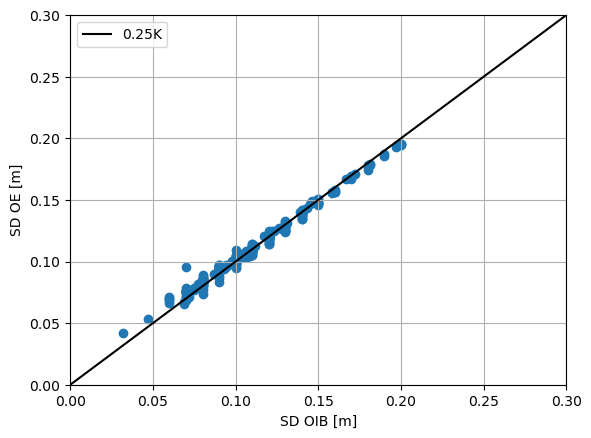

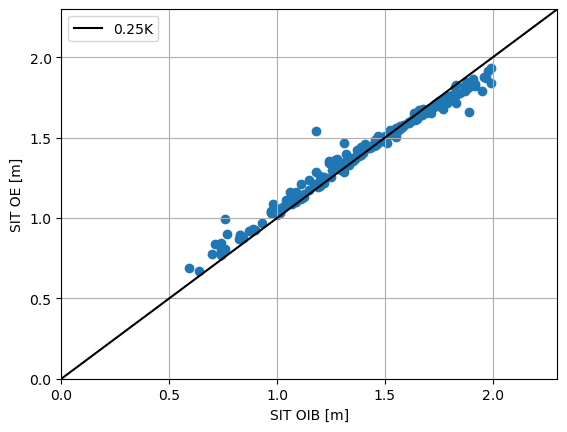

Point number:  0
0.87 s, iteration 1, degrees of freedom: 1.68 of 2, not converged (x-space):  0.281
1.24 s, iteration 2, degrees of freedom: 1.68 of 2, converged (x-space):  0.000
1.59 s, iteration 3, degrees of freedom: 1.68 of 2, done.  0.000
Point number:  1
0.86 s, iteration 1, degrees of freedom: 1.57 of 2, converged (x-space):  0.009
1.23 s, iteration 2, degrees of freedom: 1.56 of 2, done.  0.000
Point number:  2
0.86 s, iteration 1, degrees of freedom: 1.58 of 2, not converged (x-space):  0.308
1.23 s, iteration 2, degrees of freedom: 1.57 of 2, converged (x-space):  0.000
1.59 s, iteration 3, degrees of freedom: 1.57 of 2, done.  0.000
Point number:  3
0.87 s, iteration 1, degrees of freedom: 1.31 of 2, converged (x-space):  0.131
1.25 s, iteration 2, degrees of freedom: 1.38 of 2, done.  0.006
Point number:  4
0.86 s, iteration 1, degrees of freedom: 1.39 of 2, not converged (x-space):  0.830
1.22 s, iteration 2, degrees of freedom: 1.42 of 2, converged (x-space):  0.017
1.6

2.31 s, iteration 5, degrees of freedom: 1.71 of 2, done.  0.007
Point number:  40
0.87 s, iteration 1, degrees of freedom: 1.56 of 2, not converged (x-space):  1.670
1.25 s, iteration 2, degrees of freedom: 1.63 of 2, converged (x-space):  0.035
1.61 s, iteration 3, degrees of freedom: 1.61 of 2, done.  0.002
Point number:  41
0.92 s, iteration 1, degrees of freedom: 1.51 of 2, converged (x-space):  0.010
1.31 s, iteration 2, degrees of freedom: 1.51 of 2, done.  0.000
Point number:  42
0.89 s, iteration 1, degrees of freedom: 1.78 of 2, not converged (x-space):  0.511
1.28 s, iteration 2, degrees of freedom: 1.72 of 2, converged (x-space):  0.011
1.66 s, iteration 3, degrees of freedom: 1.73 of 2, done.  0.000
Point number:  43
0.89 s, iteration 1, degrees of freedom: 1.77 of 2, not converged (x-space):  1.759
1.26 s, iteration 2, degrees of freedom: 1.71 of 2, converged (x-space):  0.081
1.63 s, iteration 3, degrees of freedom: 1.72 of 2, done.  0.001
Point number:  44
0.87 s, itera

1.20 s, iteration 2, degrees of freedom: 1.50 of 2, converged (x-space):  0.000
1.56 s, iteration 3, degrees of freedom: 1.50 of 2, done.  0.000
Point number:  80
0.85 s, iteration 1, degrees of freedom: 1.68 of 2, converged (x-space):  0.059
1.23 s, iteration 2, degrees of freedom: 1.67 of 2, done.  0.000
Point number:  81
0.85 s, iteration 1, degrees of freedom: 1.96 of 2, converged (x-space):  0.030
1.21 s, iteration 2, degrees of freedom: 1.96 of 2, done.  0.011
Point number:  82
0.86 s, iteration 1, degrees of freedom: 1.54 of 2, not converged (x-space):  0.597
1.23 s, iteration 2, degrees of freedom: 1.52 of 2, converged (x-space):  0.003
1.60 s, iteration 3, degrees of freedom: 1.52 of 2, done.  0.000
Point number:  83
0.86 s, iteration 1, degrees of freedom: 1.43 of 2, not converged (x-space):  7.190
1.22 s, iteration 2, degrees of freedom: 1.33 of 2, not converged (x-space):  0.406
1.57 s, iteration 3, degrees of freedom: 1.34 of 2, converged (x-space):  0.001
1.94 s, iteratio

1.24 s, iteration 2, degrees of freedom: 1.90 of 2, not converged (x-space):  1.239
1.60 s, iteration 3, degrees of freedom: 1.90 of 2, not converged (x-space):  0.977
1.96 s, iteration 4, degrees of freedom: 1.89 of 2, not converged (x-space):  0.770
2.32 s, iteration 5, degrees of freedom: 1.89 of 2, not converged (x-space):  0.606
2.67 s, iteration 6, degrees of freedom: 1.89 of 2, not converged (x-space):  0.476
3.03 s, iteration 7, degrees of freedom: 1.89 of 2, not converged (x-space):  0.373
3.41 s, iteration 8, degrees of freedom: 1.88 of 2, not converged (x-space):  0.292
3.77 s, iteration 9, degrees of freedom: 1.88 of 2, not converged (x-space):  0.228
Point number:  118
0.84 s, iteration 1, degrees of freedom: 1.48 of 2, not converged (x-space):  8.818
1.20 s, iteration 2, degrees of freedom: 1.51 of 2, converged (x-space):  0.084
1.57 s, iteration 3, degrees of freedom: 1.53 of 2, done.  0.001
Point number:  119
0.87 s, iteration 1, degrees of freedom: 1.78 of 2, converged

1.21 s, iteration 2, degrees of freedom: 1.62 of 2, converged (x-space):  0.194
1.58 s, iteration 3, degrees of freedom: 1.82 of 2, done.  0.055
Point number:  150
0.86 s, iteration 1, degrees of freedom: 1.46 of 2, not converged (x-space):  6.465
1.24 s, iteration 2, degrees of freedom: 1.84 of 2, not converged (x-space):  0.979
1.62 s, iteration 3, degrees of freedom: 1.84 of 2, not converged (x-space):  0.775
1.99 s, iteration 4, degrees of freedom: 1.84 of 2, not converged (x-space):  0.551
2.35 s, iteration 5, degrees of freedom: 1.85 of 2, not converged (x-space):  0.402
2.71 s, iteration 6, degrees of freedom: 1.85 of 2, not converged (x-space):  0.295
3.08 s, iteration 7, degrees of freedom: 1.86 of 2, not converged (x-space):  0.218
3.46 s, iteration 8, degrees of freedom: 1.86 of 2, converged (x-space):  0.161
3.81 s, iteration 9, degrees of freedom: 1.86 of 2, done.  0.120
Point number:  151
0.84 s, iteration 1, degrees of freedom: 1.62 of 2, not converged (x-space):  0.206


1.62 s, iteration 3, degrees of freedom: 1.76 of 2, done.  0.000
Point number:  175
0.89 s, iteration 1, degrees of freedom: 1.78 of 2, not converged (x-space):  0.267
1.26 s, iteration 2, degrees of freedom: 1.79 of 2, converged (x-space):  0.018
1.63 s, iteration 3, degrees of freedom: 1.79 of 2, done.  0.001
Point number:  176
0.86 s, iteration 1, degrees of freedom: 1.66 of 2, converged (x-space):  0.107
1.21 s, iteration 2, degrees of freedom: 1.67 of 2, done.  0.001
Point number:  177
0.84 s, iteration 1, degrees of freedom: 1.63 of 2, converged (x-space):  0.013
1.20 s, iteration 2, degrees of freedom: 1.62 of 2, done.  0.000
Point number:  178
0.86 s, iteration 1, degrees of freedom: 1.84 of 2, not converged (x-space):  0.471
1.23 s, iteration 2, degrees of freedom: 1.47 of 2, not converged (x-space):  0.666
1.60 s, iteration 3, degrees of freedom: 1.44 of 2, converged (x-space):  0.007
1.96 s, iteration 4, degrees of freedom: 1.44 of 2, done.  0.000
Point number:  179
0.83 s, 

1.58 s, iteration 3, degrees of freedom: 1.16 of 2, not converged (x-space):  0.316
1.92 s, iteration 4, degrees of freedom: 1.35 of 2, converged (x-space):  0.014
2.28 s, iteration 5, degrees of freedom: 1.36 of 2, done.  0.002
Point number:  206
0.85 s, iteration 1, degrees of freedom: 1.07 of 2, not converged (x-space):  37.291
1.22 s, iteration 2, degrees of freedom: 1.17 of 2, not converged (x-space):  7.141
1.57 s, iteration 3, degrees of freedom: 1.27 of 2, converged (x-space):  0.063
1.94 s, iteration 4, degrees of freedom: 1.29 of 2, done.  0.000
Point number:  207
0.87 s, iteration 1, degrees of freedom: 1.70 of 2, converged (x-space):  0.082
1.25 s, iteration 2, degrees of freedom: 1.69 of 2, done.  0.002
Point number:  208
0.90 s, iteration 1, degrees of freedom: 1.50 of 2, not converged (x-space):  6.669
1.26 s, iteration 2, degrees of freedom: 1.81 of 2, converged (x-space):  0.007
1.62 s, iteration 3, degrees of freedom: 1.81 of 2, done.  0.004
Point number:  209
0.86 s,

1.33 s, iteration 2, degrees of freedom: 1.68 of 2, done.  0.001
Point number:  234
0.83 s, iteration 1, degrees of freedom: 1.71 of 2, not converged (x-space):  0.280
1.18 s, iteration 2, degrees of freedom: 1.71 of 2, converged (x-space):  0.000
1.53 s, iteration 3, degrees of freedom: 1.71 of 2, done.  0.000
Point number:  235
0.82 s, iteration 1, degrees of freedom: 1.74 of 2, not converged (x-space):  3.501
1.18 s, iteration 2, degrees of freedom: 1.73 of 2, converged (x-space):  0.123
1.54 s, iteration 3, degrees of freedom: 1.73 of 2, done.  0.003
Point number:  236
0.87 s, iteration 1, degrees of freedom: 1.76 of 2, not converged (x-space):  13.022
1.22 s, iteration 2, degrees of freedom: 1.73 of 2, converged (x-space):  0.024
1.59 s, iteration 3, degrees of freedom: 1.73 of 2, done.  0.000
Point number:  237
0.85 s, iteration 1, degrees of freedom: 1.70 of 2, not converged (x-space):  13.134
1.21 s, iteration 2, degrees of freedom: 1.73 of 2, converged (x-space):  0.042
1.56 s

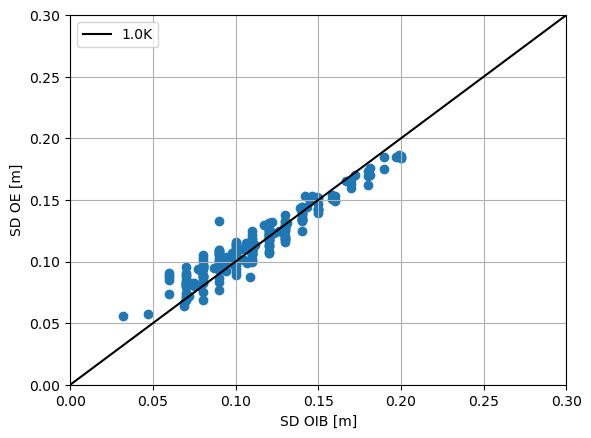

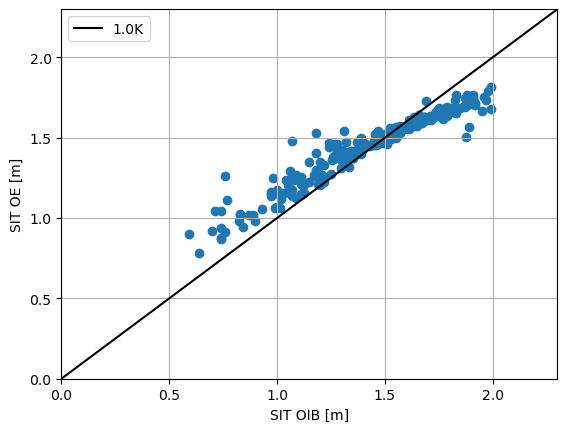

Point number:  0
0.84 s, iteration 1, degrees of freedom: 1.24 of 2, converged (x-space):  0.017
1.19 s, iteration 2, degrees of freedom: 1.24 of 2, done.  0.000
Point number:  1
0.85 s, iteration 1, degrees of freedom: 1.14 of 2, converged (x-space):  0.000
1.23 s, iteration 2, degrees of freedom: 1.14 of 2, done.  0.000
Point number:  2
0.87 s, iteration 1, degrees of freedom: 1.13 of 2, converged (x-space):  0.045
1.25 s, iteration 2, degrees of freedom: 1.12 of 2, done.  0.000
Point number:  3
0.87 s, iteration 1, degrees of freedom: 1.00 of 2, converged (x-space):  0.018
1.24 s, iteration 2, degrees of freedom: 1.03 of 2, done.  0.001
Point number:  4
0.82 s, iteration 1, degrees of freedom: 0.98 of 2, converged (x-space):  0.107
1.18 s, iteration 2, degrees of freedom: 1.01 of 2, done.  0.002
Point number:  5
0.85 s, iteration 1, degrees of freedom: 0.96 of 2, converged (x-space):  0.009
1.21 s, iteration 2, degrees of freedom: 0.96 of 2, done.  0.000
Point number:  6
0.84 s, ite

1.25 s, iteration 2, degrees of freedom: 1.14 of 2, done.  0.000
Point number:  47
0.86 s, iteration 1, degrees of freedom: 1.30 of 2, converged (x-space):  0.028
1.23 s, iteration 2, degrees of freedom: 1.30 of 2, done.  0.000
Point number:  48
0.83 s, iteration 1, degrees of freedom: 1.37 of 2, converged (x-space):  0.102
1.20 s, iteration 2, degrees of freedom: 1.35 of 2, done.  0.004
Point number:  49
0.83 s, iteration 1, degrees of freedom: 1.37 of 2, converged (x-space):  0.115
1.20 s, iteration 2, degrees of freedom: 1.37 of 2, done.  0.001
Point number:  50
0.85 s, iteration 1, degrees of freedom: 1.33 of 2, converged (x-space):  0.065
1.22 s, iteration 2, degrees of freedom: 1.34 of 2, done.  0.000
Point number:  51
0.85 s, iteration 1, degrees of freedom: 1.18 of 2, converged (x-space):  0.000
1.21 s, iteration 2, degrees of freedom: 1.18 of 2, done.  0.000
Point number:  52
0.86 s, iteration 1, degrees of freedom: 1.13 of 2, converged (x-space):  0.015
1.24 s, iteration 2, d

1.22 s, iteration 2, degrees of freedom: 1.21 of 2, done.  0.000
Point number:  92
0.82 s, iteration 1, degrees of freedom: 1.17 of 2, converged (x-space):  0.003
1.17 s, iteration 2, degrees of freedom: 1.17 of 2, done.  0.000
Point number:  93
0.84 s, iteration 1, degrees of freedom: 1.55 of 2, converged (x-space):  0.003
1.20 s, iteration 2, degrees of freedom: 1.55 of 2, done.  0.001
Point number:  94
0.84 s, iteration 1, degrees of freedom: 1.84 of 2, not converged (x-space):  0.266
1.20 s, iteration 2, degrees of freedom: 1.69 of 2, converged (x-space):  0.001
1.57 s, iteration 3, degrees of freedom: 1.69 of 2, done.  0.001
Point number:  95
0.78 s, iteration 1, degrees of freedom: 1.28 of 2, converged (x-space):  0.018
1.11 s, iteration 2, degrees of freedom: 1.28 of 2, done.  0.000
Point number:  96
0.82 s, iteration 1, degrees of freedom: 1.30 of 2, converged (x-space):  0.009
1.15 s, iteration 2, degrees of freedom: 1.30 of 2, done.  0.000
Point number:  97
0.83 s, iteration 

1.57 s, iteration 3, degrees of freedom: 1.23 of 2, done.  0.000
Point number:  127
0.80 s, iteration 1, degrees of freedom: 1.33 of 2, converged (x-space):  0.005
1.16 s, iteration 2, degrees of freedom: 1.34 of 2, done.  0.000
Point number:  128
0.83 s, iteration 1, degrees of freedom: 1.35 of 2, converged (x-space):  0.000
1.19 s, iteration 2, degrees of freedom: 1.35 of 2, done.  0.000
Point number:  129
0.85 s, iteration 1, degrees of freedom: 1.30 of 2, converged (x-space):  0.017
1.20 s, iteration 2, degrees of freedom: 1.36 of 2, done.  0.000
Point number:  130
0.81 s, iteration 1, degrees of freedom: 1.38 of 2, converged (x-space):  0.066
1.16 s, iteration 2, degrees of freedom: 1.50 of 2, done.  3.891
Point number:  131
0.82 s, iteration 1, degrees of freedom: 1.28 of 2, converged (x-space):  0.000
1.17 s, iteration 2, degrees of freedom: 1.28 of 2, done.  0.000
Point number:  132
0.80 s, iteration 1, degrees of freedom: 1.24 of 2, converged (x-space):  0.000
1.15 s, iteratio

1.22 s, iteration 2, degrees of freedom: 1.02 of 2, converged (x-space):  0.004
1.58 s, iteration 3, degrees of freedom: 1.02 of 2, done.  0.000
Point number:  168
0.89 s, iteration 1, degrees of freedom: 1.02 of 2, not converged (x-space):  0.937
1.28 s, iteration 2, degrees of freedom: 1.02 of 2, converged (x-space):  0.008
1.62 s, iteration 3, degrees of freedom: 1.02 of 2, done.  0.000
Point number:  169
0.79 s, iteration 1, degrees of freedom: 1.01 of 2, not converged (x-space):  0.798
1.13 s, iteration 2, degrees of freedom: 1.00 of 2, converged (x-space):  0.024
1.48 s, iteration 3, degrees of freedom: 1.00 of 2, done.  0.000
Point number:  170
0.83 s, iteration 1, degrees of freedom: 1.04 of 2, not converged (x-space):  1.008
1.19 s, iteration 2, degrees of freedom: 1.04 of 2, converged (x-space):  0.016
1.53 s, iteration 3, degrees of freedom: 1.05 of 2, done.  0.000
Point number:  171
0.81 s, iteration 1, degrees of freedom: 1.00 of 2, not converged (x-space):  0.446
1.17 s, 

1.24 s, iteration 2, degrees of freedom: 1.01 of 2, not converged (x-space):  0.339
1.60 s, iteration 3, degrees of freedom: 1.00 of 2, converged (x-space):  0.007
1.94 s, iteration 4, degrees of freedom: 1.01 of 2, done.  0.000
Point number:  205
0.81 s, iteration 1, degrees of freedom: 1.01 of 2, not converged (x-space):  1.933
1.16 s, iteration 2, degrees of freedom: 1.06 of 2, converged (x-space):  0.107
1.52 s, iteration 3, degrees of freedom: 1.00 of 2, done.  0.002
Point number:  206
0.83 s, iteration 1, degrees of freedom: 1.04 of 2, not converged (x-space):  1.725
1.19 s, iteration 2, degrees of freedom: 1.03 of 2, converged (x-space):  0.013
1.53 s, iteration 3, degrees of freedom: 1.47 of 2, done.  0.034
Point number:  207
0.78 s, iteration 1, degrees of freedom: 1.33 of 2, converged (x-space):  0.006
1.14 s, iteration 2, degrees of freedom: 1.33 of 2, done.  0.000
Point number:  208
0.82 s, iteration 1, degrees of freedom: 1.11 of 2, not converged (x-space):  2.692
1.17 s, 

0.89 s, iteration 1, degrees of freedom: 1.44 of 2, not converged (x-space):  0.488
1.26 s, iteration 2, degrees of freedom: 1.36 of 2, converged (x-space):  0.050
1.61 s, iteration 3, degrees of freedom: 1.35 of 2, done.  0.000
Point number:  241
1.01 s, iteration 1, degrees of freedom: 1.40 of 2, not converged (x-space):  0.401
1.35 s, iteration 2, degrees of freedom: 1.36 of 2, converged (x-space):  0.001
1.74 s, iteration 3, degrees of freedom: 1.36 of 2, done.  0.000
Point number:  242
0.87 s, iteration 1, degrees of freedom: 1.38 of 2, not converged (x-space):  0.270
1.25 s, iteration 2, degrees of freedom: 1.37 of 2, converged (x-space):  0.002
1.62 s, iteration 3, degrees of freedom: 1.37 of 2, done.  0.000
Point number:  243
0.86 s, iteration 1, degrees of freedom: 1.39 of 2, not converged (x-space):  0.286
1.21 s, iteration 2, degrees of freedom: 1.43 of 2, converged (x-space):  0.001
1.56 s, iteration 3, degrees of freedom: 1.43 of 2, done.  0.000
Point number:  244
0.83 s, 

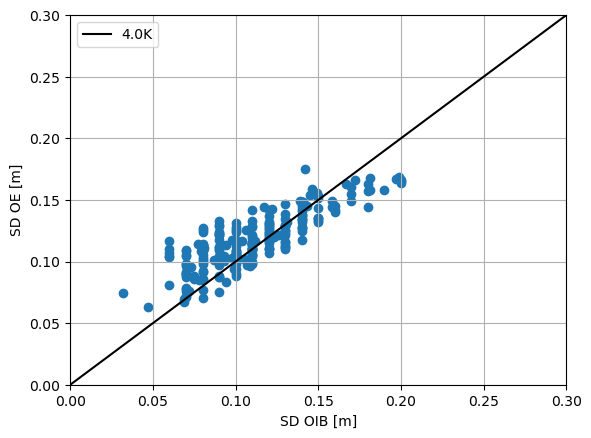

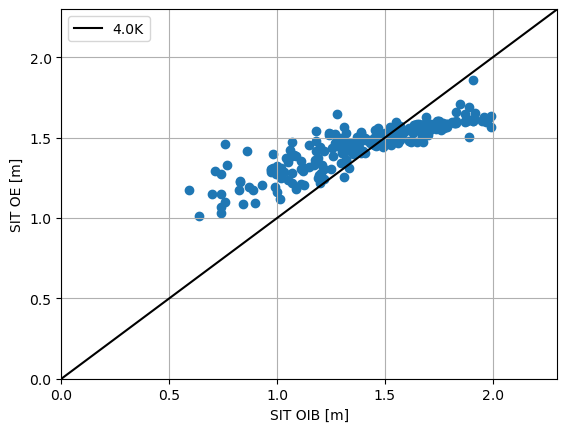

In [18]:
for sens in [0.1, 0.5, 1.0, 2.0]:
    V_sens = sens
    H_sens = sens
    y_cov = np.diag([V_sens**2]*5 + [H_sens**2]*5)

    [nn, no, oe_out, x_optimals, results] = do_OE_sim(ns)
    oe_sd = []
    oe_sit = []
    sd_OIB = []
    sit_OIB = []
    for oe,sd,sit in zip(oe_out,d_final_FYI.sd,d_final_FYI.sit):
        try:
            plt.scatter(sd, oe.x_op[0], c='C0')
            oe_sd.append(oe.x_op[0])
            oe_sit.append(oe.x_op[1])
            sd_OIB.append(sd)
            sit_OIB.append(sit)
        except:
            pass
    RSD = RMSE(sd_OIB, oe_sd)
    print(RSD)
    RSIT = RMSE(sit_OIB, oe_sit)
    print(RSIT)
    plt.grid()
    plt.xlim([0,0.30])
    plt.ylim([0,0.30])
    x = np.linspace(0,0.30,10)
    plt.plot(x,x, c='k',  label=str(np.round(sens**2,2)) + 'K')
    plt.legend()
    plt.xlabel('SD OIB [m]')
    plt.ylabel('SD OE [m]')
    plt.show()


    plt.scatter(sit_OIB, oe_sit, c='C0')
    plt.grid()
    plt.xlim([0,2.3])
    plt.ylim([0,2.3])
    x = np.linspace(0,2.3,10)
    plt.plot(x,x, c='k',  label=str(np.round(sens**2,2)) + 'K')
    plt.legend()
    plt.xlabel('SIT OIB [m]')
    plt.ylabel('SIT OE [m]')
    plt.show()

In [ ]:
# nn = [i for i in range(ns)]
nn  = np.array(nn, dtype=int)
nnn = np.delete(nn, no)
no  = np.array(np.unique(no), dtype=int)

fig, ax = plt.subplots(3, figsize=(7,10), sharex=False)

vars = ['SD', 'SIT', 'Tsur']
xlabel = ['m', 'm','K']
xlim = [[0,0.4], [0,3], [240, 270]]
binss = [np.linspace(0, 1, 50), np.linspace(0, 5, 100), np.linspace(230, 270, 50)]
# bins = 
for var, i in zip([10**FYI_data.sd, FYI_data.sit, FYI_data.skt], range(3)):
    bins = binss[i]
    ax[i].hist(var[nnn], bins=bins, rwidth=0.85, alpha=0.5, label = 'converged, ' + str(len(nnn)))
    ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])
    
plt.legend(bbox_to_anchor=(1.35, 3.3))
plt.savefig(savepath + str(slope_std) +'_hist.png', bbox_inches='tight')

In [ ]:
import math
# nn = [i for i in range(ns)]
nn  = np.array(nn, dtype=int)
nnn = nn # np.delete(nn, no)
# no  = np.array(np.unique(no), dtype=int)

SD_OE = [oe.x_op[0] for oe in np.array(oe_out)[nnn]]
rho_OE = [oe.x_op[1] for oe in np.array(oe_out)[nnn]]
sal_OE = [oe.x_op[2] for oe in np.array(oe_out)[nnn]]
slope_OE = [oe.x_op[3] for oe in np.array(oe_out)[nnn]]
# tsk_OE = [oe.x_op[4] for oe in np.array(oe_out)[nnn]]


vars = ['SD', 'rho', 'sal', ' slope']
xlabel = ['m', 'kg/m3', '', '']
xlim = [[0,0.4], [150, 450], [5/1000,20/1000],[0.05, 0.5]]
binss = [np.linspace(0, 1, 100), np.linspace(200, 400, 100),
         np.linspace(0, 20/1000, 100),
         np.linspace(0.1, 0.4, 100)]

std_diag = np.sqrt(np.diag(x_cov))
std_diag[0] = 10**std_diag[0]

fig, ax = plt.subplots(4, figsize=(7,10), sharex=False)
for var, i in zip([SD_OE, rho_OE, sal_OE, slope_OE], range(4)):
    bins = binss[i]
    ax[i].hist(np.array(var), bins=bins, rwidth=0.85, alpha=0.5)
    # ax[i].hist(var[no], bins=bins, rwidth=0.85, alpha=0.5, label='not converged, ' + str(len(no)))
    ax[i].axvline(np.array(var).mean(), color='r', linestyle='dashed', linewidth=1)
    ## the "input cov std"
    ax[i].axvline(np.array(var).mean()-std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+std_diag[i], color='k', linestyle='dashed', linewidth=1)
    ## the real std
    ax[i].axvline(np.array(var).mean()-np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].axvline(np.array(var).mean()+np.array(var).std(), color='r', linestyle='dashed', linewidth=1)
    ax[i].set_yticks([])
    ax[i].set_ylabel(str(vars[i]))
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_xlim(xlim[i])

In [ ]:
SD_OE

In [ ]:
## degrees of freedom
rel = np.array(oe_out)[nnn]
df = [r.dgf for r in rel]
plt.figure(figsize=(6,6))
plt.scatter(nnn, df)
plt.grid()
plt.title('Degrees of freedom')
plt.xlabel('point')
plt.ylabel('dgf')
plt.ylim(0,4)
plt.savefig(savepath + '_degrees of freedom.png' )
plt.show()

In [ ]:
#rel = np.array(oe_out)[BD.astype(int)]
rel = np.array(oe_out)[nnn][BD.astype(int)]

oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='bad_out')



In [ ]:
#rel = np.array(oe_out)[BD.astype(int)]
good = np.delete(nnn, BD.astype(int))
rel = np.array(oe_out)[good]

oe_comb = np.mean([r.S_op for r in rel], axis=0)
oe_show = makeOEobject(x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_OIB_AMSR2)
covOutMat(oe_comb, oe_show.S_a, name='good_out')



In [ ]:
FYI_data.lat[BD]
FYI_data.lon[BD]
FYI_data.date[BD]

In [ ]:
FYI_data.date[nn[:-1]]

In [ ]:
FYI_data.date[no]

In [ ]:
from polar_plots_pred import polar_plot as pp

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[no] 
FYI_data_plot.lon = FYI_data.lon[no]
FYI_data_plot.sit = FYI_data.sit[no]
title= 'not converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=20)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)

FYI_data_plot.lat = FYI_data.lat[nn[:-1]] 
FYI_data_plot.lon = FYI_data.lon[nn[:-1]]
FYI_data_plot.sit = FYI_data.sit[nn[:-1]]
title= 'Converged'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=7)

In [ ]:
FYI_data_plot = OIB_data('FYI', new=True)
FYI_data_plot.lat = FYI_data.lat[BD] 
FYI_data_plot.lon = FYI_data.lon[BD]
FYI_data_plot.sit = FYI_data.sit[BD]
title= 'RMSE Large'

pp(FYI_data_plot, FYI_data_plot.sit, title, ylabel='SIT [m]', clim=False, savename=False, saveloc=False, s=8)